In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270822 entries, 0 to 2270821
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 34.7 MB


# reduce to 1 million events

In [4]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [5]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,33729,0.11,33.729
1,33841,0.11,33.841
2,33815,0.11,33.815
3,33583,0.11,33.583
4,33662,0.11,33.662
...,...,...,...
999995,17767,0.20,17.767
999996,17347,0.21,17.347
999997,17325,0.21,17.325
999998,16996,0.21,16.996


### conversion Interval -> kWh

In [6]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,33729,0.11,33.729,106.733078
1,33841,0.11,33.841,106.379835
2,33815,0.11,33.815,106.461629
3,33583,0.11,33.583,107.197094
4,33662,0.11,33.662,106.945517
...,...,...,...,...
999995,17767,0.20,17.767,202.622840
999996,17347,0.21,17.347,207.528679
999997,17325,0.21,17.325,207.792208
999998,16996,0.21,16.996,211.814545


### Cumul Total interval

In [7]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [8]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26080547297000

### Calcul de la date de base = now - cumul_interval

In [9]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 8, 3, 0, 6, 51, 261679)

In [10]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [11]:
conso_data.iloc[0]


Interval     33729.000000
kWh              0.110000
sec             33.729000
Wh             106.733078
cumul(ms)    33729.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [12]:
base

datetime.datetime(2024, 8, 3, 0, 6, 51, 261679)

## créer les dates

In [13]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-08-03 00:07:24.990679
1        2024-08-03 00:07:58.831679
2        2024-08-03 00:08:32.646679
3        2024-08-03 00:09:06.229679
4        2024-08-03 00:09:39.891679
                    ...            
999995   2025-05-31 20:41:29.574679
999996   2025-05-31 20:41:46.921679
999997   2025-05-31 20:42:04.246679
999998   2025-05-31 20:42:21.242679
999999   2025-05-31 20:42:38.558679
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [14]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,33729,0.11,33.729,106.733078,33729,2024-08-03 00:07:24.990679,03/08/24
1,33841,0.11,33.841,106.379835,67570,2024-08-03 00:07:58.831679,03/08/24
2,33815,0.11,33.815,106.461629,101385,2024-08-03 00:08:32.646679,03/08/24
3,33583,0.11,33.583,107.197094,134968,2024-08-03 00:09:06.229679,03/08/24
4,33662,0.11,33.662,106.945517,168630,2024-08-03 00:09:39.891679,03/08/24
...,...,...,...,...,...,...,...
999995,17767,0.20,17.767,202.622840,26080478313,2025-05-31 20:41:29.574679,31/05/25
999996,17347,0.21,17.347,207.528679,26080495660,2025-05-31 20:41:46.921679,31/05/25
999997,17325,0.21,17.325,207.792208,26080512985,2025-05-31 20:42:04.246679,31/05/25
999998,16996,0.21,16.996,211.814545,26080529981,2025-05-31 20:42:21.242679,31/05/25


### save conso_data with dates

In [15]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [16]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('31/05/25', 31, 5, 2025, '20:42:52')

In [17]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [18]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2235 entries, 997765 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2235 non-null   int64         
 1   kWh        2235 non-null   float64       
 2   sec        2235 non-null   float64       
 3   Wh         2235 non-null   float64       
 4   cumul(ms)  2235 non-null   int64         
 5   dates      2235 non-null   datetime64[ns]
 6   days       2235 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 139.7+ KB


In [19]:
end = time.time()
print(end - start)

15.879801750183105


### grouped by days

In [20]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [21]:
data = list(df_grp['kWh'])
print(data)

[3.309, 3.341, 3.511, 3.64, 3.495, 3.686, 3.722, 3.917, 3.654, 4.375, 4.321, 3.909, 3.873, 4.04, 3.781, 3.871, 3.704, 3.278, 3.926, 3.953, 4.372, 3.845, 4.107, 3.794, 3.976, 3.751, 3.985, 3.654, 3.654, 3.499, 3.683, 3.503, 4.146, 3.712, 3.446, 3.562, 3.223, 2.479, 1.795, 1.792, 1.794, 1.795, 2.471, 1.867, 1.788, 1.792, 1.79, 1.82, 1.822, 1.815, 1.817, 1.818, 1.818, 1.815, 1.814, 1.785, 1.786, 1.786, 1.786, 1.782, 1.797, 1.788, 1.79, 1.785, 1.796, 1.802, 1.795, 1.804, 1.796, 1.785, 1.789, 1.785, 1.791, 1.797, 1.791, 1.8, 1.804, 1.794, 1.8, 1.798, 2.772, 4.0, 3.66, 3.893, 3.107, 3.532, 4.056, 3.425, 3.376, 3.982, 3.341, 4.167, 3.091, 4.031, 3.156, 3.346, 3.471, 4.016, 3.289, 3.373, 3.824, 3.226, 3.525, 3.362, 3.875, 3.312, 3.464, 3.704, 4.465, 3.639, 3.853, 3.448, 4.106, 3.498, 3.407, 3.354, 3.825, 3.733, 4.069, 3.54, 3.47, 3.703, 3.17, 3.679, 3.745, 3.326, 3.847, 3.238, 4.058, 3.394, 3.829, 3.985, 3.473, 4.476, 3.208, 3.528, 3.111, 3.202, 3.531, 3.283, 3.341, 3.492, 4.738, 4.339, 3.265,

In [22]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [23]:
end = time.time()
print(end - start)

16.161866188049316


### plot function by day
#### show('dd/mm/yy')

In [24]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


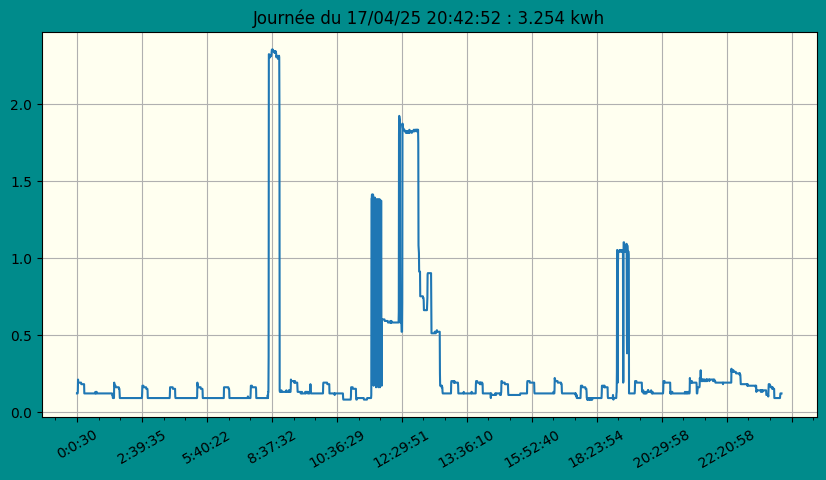

In [25]:
show('17/04/25')

In [26]:
end = time.time()
print(end - start)

17.729353189468384


### 1 kWh window in data of one day
#### df = conso_day

In [27]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997765,27558,0.13,27.558,130.633573,26006001983,2025-05-31 00:00:13.244679,31/05/25
997766,26623,0.14,26.623,135.221425,26006028606,2025-05-31 00:00:39.867679,31/05/25
997767,26636,0.14,26.636,135.155429,26006055242,2025-05-31 00:01:06.503679,31/05/25
997768,27594,0.13,27.594,130.463144,26006082836,2025-05-31 00:01:34.097679,31/05/25
997769,27519,0.13,27.519,130.818707,26006110355,2025-05-31 00:02:01.616679,31/05/25
...,...,...,...,...,...,...,...
999995,17767,0.20,17.767,202.622840,26080478313,2025-05-31 20:41:29.574679,31/05/25
999996,17347,0.21,17.347,207.528679,26080495660,2025-05-31 20:41:46.921679,31/05/25
999997,17325,0.21,17.325,207.792208,26080512985,2025-05-31 20:42:04.246679,31/05/25
999998,16996,0.21,16.996,211.814545,26080529981,2025-05-31 20:42:21.242679,31/05/25


In [28]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [29]:
df = conso_day
len(df)

2235

In [30]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-05-31 00:00:13.244679	2025-05-31 09:45:54.216679	9h 45m 40s 	1000
2025-05-31 09:45:54.216679	2025-05-31 18:47:22.552679	9h 1m 28s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.303735
dtype: float64

In [32]:
end = time.time()
print(end - start)

18.056885480880737


## mean for data grouped by days

In [33]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.311258
dtype: float64

In [34]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.235)

# conso by date


In [35]:
# select day
day = today

#day = '16/08/24'
day

'31/05/25'

In [36]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997765,27558,0.13,27.558,130.633573,26006001983,2025-05-31 00:00:13.244679,31/05/25
997766,26623,0.14,26.623,135.221425,26006028606,2025-05-31 00:00:39.867679,31/05/25
997767,26636,0.14,26.636,135.155429,26006055242,2025-05-31 00:01:06.503679,31/05/25
997768,27594,0.13,27.594,130.463144,26006082836,2025-05-31 00:01:34.097679,31/05/25
997769,27519,0.13,27.519,130.818707,26006110355,2025-05-31 00:02:01.616679,31/05/25
...,...,...,...,...,...,...,...
999995,17767,0.20,17.767,202.622840,26080478313,2025-05-31 20:41:29.574679,31/05/25
999996,17347,0.21,17.347,207.528679,26080495660,2025-05-31 20:41:46.921679,31/05/25
999997,17325,0.21,17.325,207.792208,26080512985,2025-05-31 20:42:04.246679,31/05/25
999998,16996,0.21,16.996,211.814545,26080529981,2025-05-31 20:42:21.242679,31/05/25


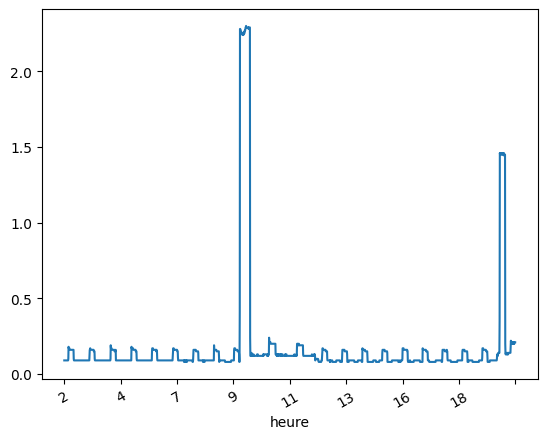

In [37]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [38]:
end = time.time()
print(end - start)

18.93135094642639


### grouped by 'heure'

In [39]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2235 entries, 997765 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2235 non-null   int64         
 1   kWh        2235 non-null   float64       
 2   sec        2235 non-null   float64       
 3   Wh         2235 non-null   float64       
 4   cumul(ms)  2235 non-null   int64         
 5   dates      2235 non-null   datetime64[ns]
 6   days       2235 non-null   object        
 7   heure      2235 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 157.1+ KB


In [40]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997765,27558,0.13,27.558,130.633573,26006001983,2025-05-31 00:00:13.244679,31/05/25
997766,26623,0.14,26.623,135.221425,26006028606,2025-05-31 00:00:39.867679,31/05/25
997767,26636,0.14,26.636,135.155429,26006055242,2025-05-31 00:01:06.503679,31/05/25
997768,27594,0.13,27.594,130.463144,26006082836,2025-05-31 00:01:34.097679,31/05/25
997769,27519,0.13,27.519,130.818707,26006110355,2025-05-31 00:02:01.616679,31/05/25
...,...,...,...,...,...,...,...
999995,17767,0.20,17.767,202.622840,26080478313,2025-05-31 20:41:29.574679,31/05/25
999996,17347,0.21,17.347,207.528679,26080495660,2025-05-31 20:41:46.921679,31/05/25
999997,17325,0.21,17.325,207.792208,26080512985,2025-05-31 20:42:04.246679,31/05/25
999998,16996,0.21,16.996,211.814545,26080529981,2025-05-31 20:42:21.242679,31/05/25


In [41]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [42]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     122
1     103
2     101
3     100
4      99
5      99
6     105
7     101
8      98
9     145
10    136
11    132
12    100
13     96
14     95
15     97
16     99
17    102
18     98
19     96
20    111
Name: kWh, dtype: int64

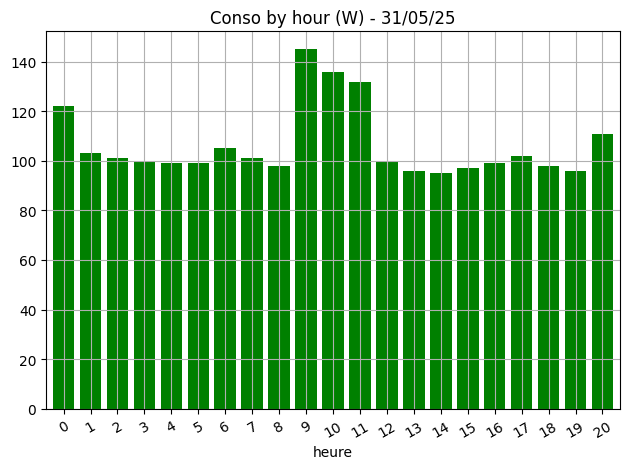

In [43]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [44]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 03/08/24 to 31/05/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     302 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [45]:
# give the periods of 1 kwh in a day
period()

2025-05-31 00:00:13.244679	2025-05-31 09:45:54.216679	9h 45m 40s 	1000


In [46]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [47]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [48]:
df_grp.mean()


kWh    3.311258
dtype: float64

In [49]:
df_grp.head()


,kWh
days,
03/08/24,3.309
04/08/24,3.341
05/08/24,3.511
06/08/24,3.640
07/08/24,3.495


In [50]:
df_grp.tail()


,kWh
days,
27/05/25,3.106
28/05/25,3.149
29/05/25,3.160
30/05/25,3.409
31/05/25,2.235


In [51]:
end = time.time()
print(end - start)

20.23058009147644


# plot les 100 derniers jours


In [52]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.36139
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

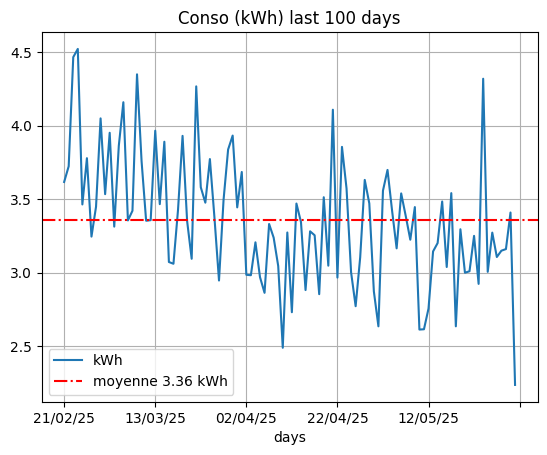

In [53]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [54]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.235
max,4.523


In [55]:
end = time.time()
print(end - start)

21.14750647544861


In [56]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('01/05/25', '26/05/25')

In [57]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.199733
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

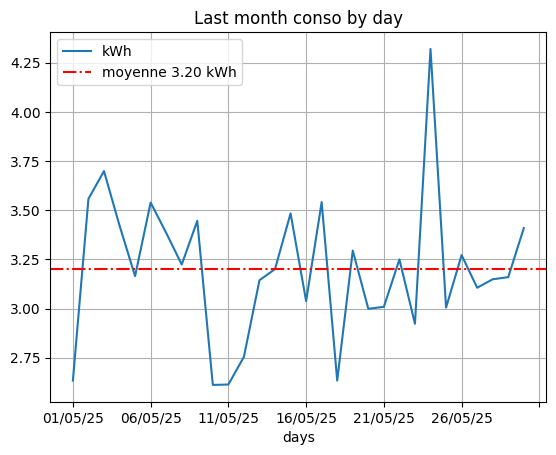

In [58]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [59]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 24/05/25 4.32
Min : 10/05/25 2.612


# Temps de conso par tranche de 1 kWh

In [60]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


3
2025-05-31 00:00:13.244679	2025-05-31 09:45:54.216679	9h 45m 40s 	1000
2025-05-31 09:45:54.216679	2025-05-31 18:47:22.552679	9h 1m 28s 	2000
2025-05-31 18:47:22.552679	2025-05-31 20:42:38.558679	1h 55m 16s 	235


In [61]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('20:42:52', 2.235, 2235)

In [62]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2235 entries, 997765 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2235 non-null   int64         
 1   kWh        2235 non-null   float64       
 2   sec        2235 non-null   float64       
 3   Wh         2235 non-null   float64       
 4   cumul(ms)  2235 non-null   int64         
 5   dates      2235 non-null   datetime64[ns]
 6   days       2235 non-null   object        
 7   heure      2235 non-null   object        
 8   hours      2235 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 174.6+ KB


In [63]:
conso_hours['heure'], conso_hours['hours']

(997765     0
 997766     0
 997767     0
 997768     0
 997769     0
           ..
 999995    20
 999996    20
 999997    20
 999998    20
 999999    20
 Name: heure, Length: 2235, dtype: object,
 997765    00
 997766    00
 997767    00
 997768    00
 997769    00
           ..
 999995    20
 999996    20
 999997    20
 999998    20
 999999    20
 Name: hours, Length: 2235, dtype: object)

In [64]:
end = time.time()
print(end - start)

21.968857049942017


# select number of days to display


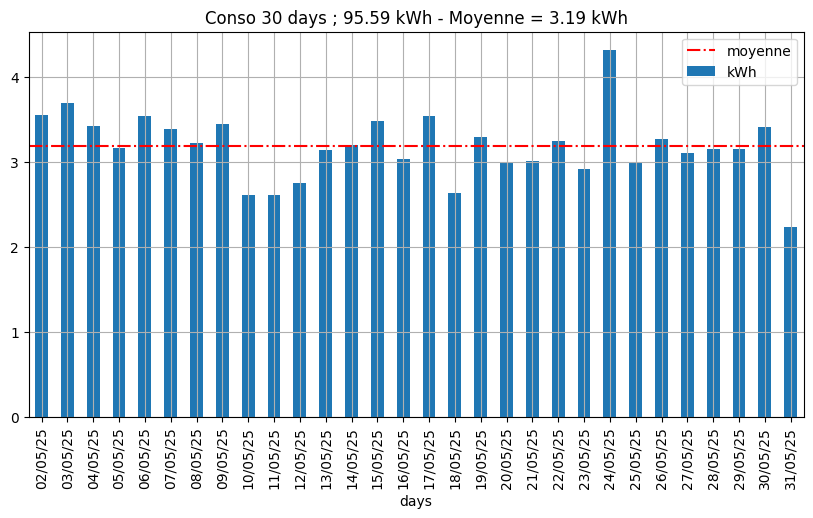

In [65]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


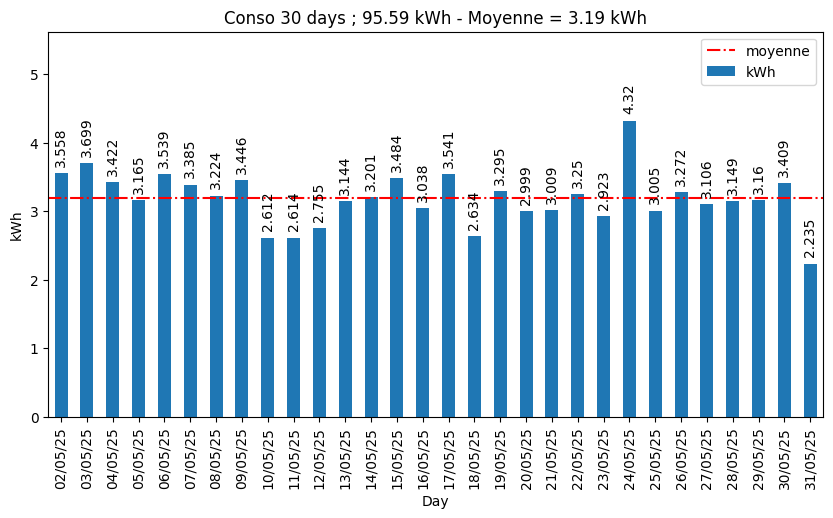

In [66]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [67]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
02/05/25    3.558
03/05/25    3.699
04/05/25    3.422
05/05/25    3.165
06/05/25    3.539
07/05/25    3.385
08/05/25    3.224
09/05/25    3.446
10/05/25    2.612
11/05/25    2.614
12/05/25    2.755
13/05/25    3.144
14/05/25    3.201
15/05/25    3.484
16/05/25    3.038
17/05/25    3.541
18/05/25    2.634
19/05/25    3.295
20/05/25    2.999
21/05/25    3.009
22/05/25    3.250
23/05/25    2.923
24/05/25    4.320
25/05/25    3.005
26/05/25    3.272
27/05/25    3.106
28/05/25    3.149
29/05/25    3.160
30/05/25    3.409
31/05/25    2.235
Name: kWh, dtype: float64

In [68]:
x_labels=df_grp.tail(span).index
x_labels

Index(['02/05/25', '03/05/25', '04/05/25', '05/05/25', '06/05/25', '07/05/25',
       '08/05/25', '09/05/25', '10/05/25', '11/05/25', '12/05/25', '13/05/25',
       '14/05/25', '15/05/25', '16/05/25', '17/05/25', '18/05/25', '19/05/25',
       '20/05/25', '21/05/25', '22/05/25', '23/05/25', '24/05/25', '25/05/25',
       '26/05/25', '27/05/25', '28/05/25', '29/05/25', '30/05/25', '31/05/25'],
      dtype='object', name='days')

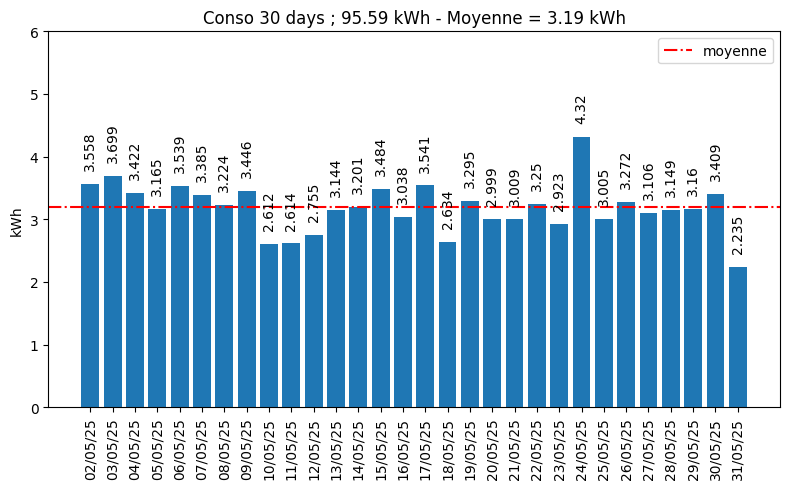

In [69]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [70]:
end = time.time()
print(end - start)

25.984337091445923


In [71]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

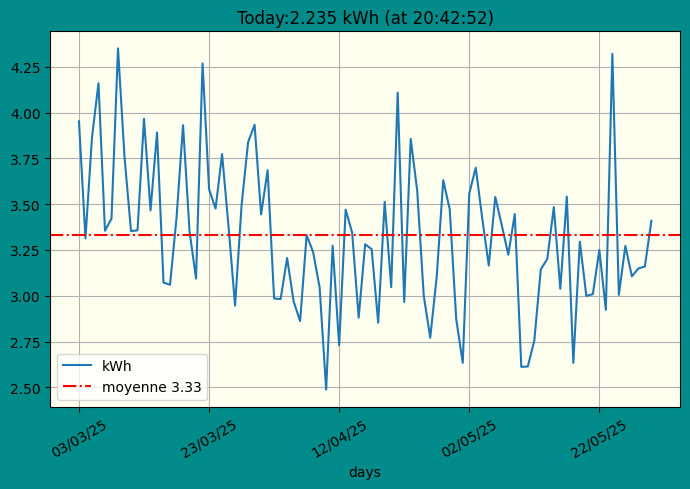

In [72]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

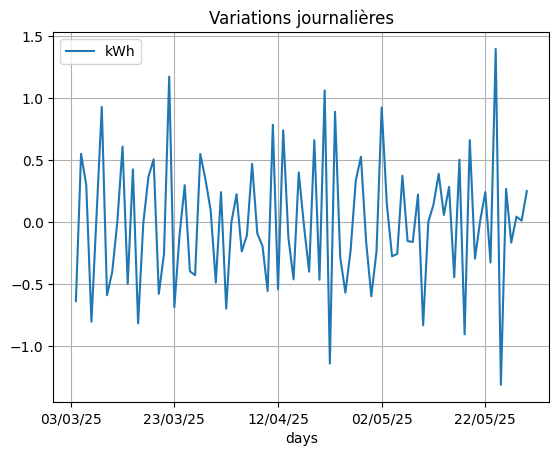

In [73]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [74]:
end = time.time()
print(end - start)

27.109018802642822


# Data from 21/08/23

In [75]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,33729,0.11,33.729,106.733078,33729,2024-08-03 00:07:24.990679,03/08/24,00,2024-08,03
1,33841,0.11,33.841,106.379835,67570,2024-08-03 00:07:58.831679,03/08/24,00,2024-08,03
2,33815,0.11,33.815,106.461629,101385,2024-08-03 00:08:32.646679,03/08/24,00,2024-08,03
3,33583,0.11,33.583,107.197094,134968,2024-08-03 00:09:06.229679,03/08/24,00,2024-08,03
4,33662,0.11,33.662,106.945517,168630,2024-08-03 00:09:39.891679,03/08/24,00,2024-08,03
...,...,...,...,...,...,...,...,...,...,...
999995,17767,0.20,17.767,202.622840,26080478313,2025-05-31 20:41:29.574679,31/05/25,20,2025-05,31
999996,17347,0.21,17.347,207.528679,26080495660,2025-05-31 20:41:46.921679,31/05/25,20,2025-05,31
999997,17325,0.21,17.325,207.792208,26080512985,2025-05-31 20:42:04.246679,31/05/25,20,2025-05,31
999998,16996,0.21,16.996,211.814545,26080529981,2025-05-31 20:42:21.242679,31/05/25,20,2025-05,31


In [76]:
end = time.time()
print(end - start)

63.814868450164795


In [77]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

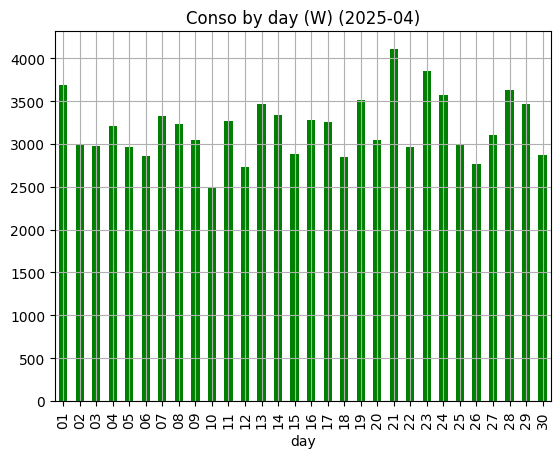

In [78]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [79]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3193.0666666666666)

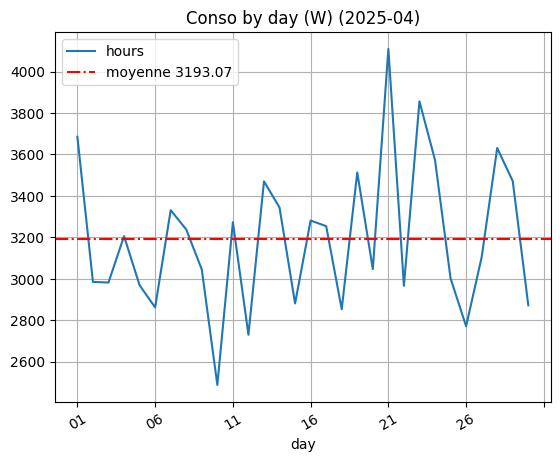

In [80]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [81]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

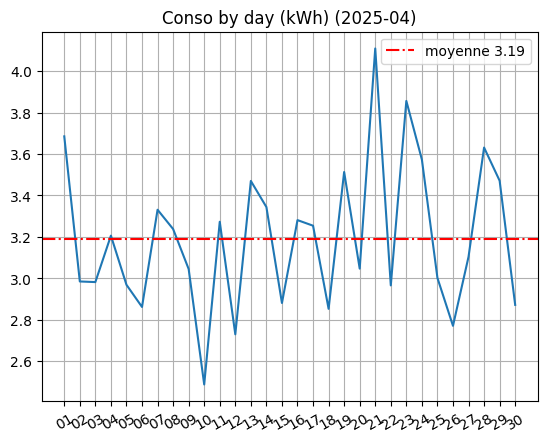

In [82]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [83]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [84]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [85]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-08,110444,110444,110444
2024-09,69819,69819,69819
2024-10,73472,73472,73472
2024-11,108510,108510,108510
2024-12,113724,113724,113724
2025-01,113695,113695,113695
2025-02,104464,104464,104464
2025-03,111853,111853,111853
2025-04,95792,95792,95792


In [86]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [87]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [88]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
03/08/24,3309
04/08/24,3341
05/08/24,3511
06/08/24,3640
07/08/24,3495
...,...
27/05/25,3106
28/05/25,3149
29/05/25,3160


In [89]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,33729,0.11,33.729,106.733078,33729,2024-08-03 00:07:24.990679,03/08/24,00,2024-08,03
1,33841,0.11,33.841,106.379835,67570,2024-08-03 00:07:58.831679,03/08/24,00,2024-08,03
2,33815,0.11,33.815,106.461629,101385,2024-08-03 00:08:32.646679,03/08/24,00,2024-08,03
3,33583,0.11,33.583,107.197094,134968,2024-08-03 00:09:06.229679,03/08/24,00,2024-08,03
4,33662,0.11,33.662,106.945517,168630,2024-08-03 00:09:39.891679,03/08/24,00,2024-08,03
...,...,...,...,...,...,...,...,...,...,...
999995,17767,0.20,17.767,202.622840,26080478313,2025-05-31 20:41:29.574679,31/05/25,20,2025-05,31
999996,17347,0.21,17.347,207.528679,26080495660,2025-05-31 20:41:46.921679,31/05/25,20,2025-05,31
999997,17325,0.21,17.325,207.792208,26080512985,2025-05-31 20:42:04.246679,31/05/25,20,2025-05,31
999998,16996,0.21,16.996,211.814545,26080529981,2025-05-31 20:42:21.242679,31/05/25,20,2025-05,31


In [90]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
03/08/24 00    0       03/08/24    00  0.11
               1       03/08/24    00  0.11
               2       03/08/24    00  0.11
               3       03/08/24    00  0.11
               4       03/08/24    00  0.11
...                         ...   ...   ...
31/05/25 20    999995  31/05/25    20  0.20
               999996  31/05/25    20  0.21
               999997  31/05/25    20  0.21
               999998  31/05/25    20  0.21
               999999  31/05/25    20  0.21

[1000000 rows x 3 columns]

In [91]:
groupallbyday.indices.keys()

dict_keys(['03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/1

In [92]:
groupallbydayhours.indices.keys()

dict_keys([('03/08/24', '00'), ('03/08/24', '01'), ('03/08/24', '02'), ('03/08/24', '03'), ('03/08/24', '04'), ('03/08/24', '05'), ('03/08/24', '06'), ('03/08/24', '07'), ('03/08/24', '08'), ('03/08/24', '09'), ('03/08/24', '10'), ('03/08/24', '11'), ('03/08/24', '12'), ('03/08/24', '13'), ('03/08/24', '14'), ('03/08/24', '15'), ('03/08/24', '16'), ('03/08/24', '17'), ('03/08/24', '18'), ('03/08/24', '19'), ('03/08/24', '20'), ('03/08/24', '21'), ('03/08/24', '22'), ('03/08/24', '23'), ('04/08/24', '00'), ('04/08/24', '01'), ('04/08/24', '02'), ('04/08/24', '03'), ('04/08/24', '04'), ('04/08/24', '05'), ('04/08/24', '06'), ('04/08/24', '07'), ('04/08/24', '08'), ('04/08/24', '09'), ('04/08/24', '10'), ('04/08/24', '11'), ('04/08/24', '12'), ('04/08/24', '13'), ('04/08/24', '14'), ('04/08/24', '15'), ('04/08/24', '16'), ('04/08/24', '17'), ('04/08/24', '18'), ('04/08/24', '19'), ('04/08/24', '20'), ('04/08/24', '21'), ('04/08/24', '22'), ('04/08/24', '23'), ('05/08/24', '00'), ('05/08/2

In [93]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
03/08/24,3309,3309
04/08/24,3341,3341
05/08/24,3511,3511
06/08/24,3640,3640
07/08/24,3495,3495
...,...,...
27/05/25,3106,3106
28/05/25,3149,3149
29/05/25,3160,3160


In [94]:
grp_by_day['kWh'].cumsum()

days
03/08/24       3309
04/08/24       6650
05/08/24      10161
06/08/24      13801
07/08/24      17296
             ...   
27/05/25     988047
28/05/25     991196
29/05/25     994356
30/05/25     997765
31/05/25    1000000
Name: kWh, Length: 302, dtype: int64

In [95]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
03/08/24 00     102
         01     127
         02     191
         03     154
         04     125
...             ...
31/05/25 16      99
         17     102
         18      98
         19      96
         20     111

[7245 rows x 1 columns]

In [96]:
grp_by_dayhours['kWh'].cumsum()

days      hours
03/08/24  00           102
          01           229
          02           420
          03           574
          04           699
                    ...   
31/05/25  16        999593
          17        999695
          18        999793
          19        999889
          20       1000000
Name: kWh, Length: 7245, dtype: int64

In [97]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
03/08/24 00     102     102   NaN
         01     127     229  25.0
         02     191     420  64.0
         03     154     574 -37.0
         04     125     699 -29.0
...             ...     ...   ...
31/05/25 16      99    1828   2.0
         17     102    1930   3.0
         18      98    2028  -4.0
         19      96    2124  -2.0
         20     111    2235  15.0

[7245 rows x 3 columns]

In [98]:
today, grp_by_dayhours.loc[today]

('31/05/25',
        kWh  cumsum  diff
 hours                   
 00     122     122   NaN
 01     103     225 -19.0
 02     101     326  -2.0
 03     100     426  -1.0
 04      99     525  -1.0
 05      99     624   0.0
 06     105     729   6.0
 07     101     830  -4.0
 08      98     928  -3.0
 09     145    1073  47.0
 10     136    1209  -9.0
 11     132    1341  -4.0
 12     100    1441 -32.0
 13      96    1537  -4.0
 14      95    1632  -1.0
 15      97    1729   2.0
 16      99    1828   2.0
 17     102    1930   3.0
 18      98    2028  -4.0
 19      96    2124  -2.0
 20     111    2235  15.0)

Text(0.5, 1.0, 'Cumul journalier')

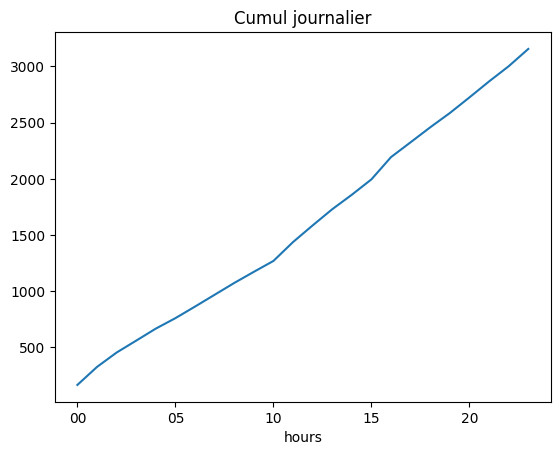

In [99]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

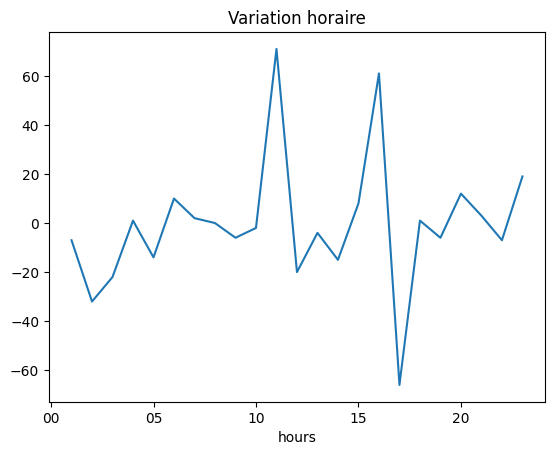

In [100]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [101]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

302

In [102]:
df_grp.tail(n)['kWh'].describe()


count    302.000000
mean       3.311258
std        0.728457
min        1.782000
25%        3.096500
50%        3.429000
75%        3.771250
max        4.885000
Name: kWh, dtype: float64

In [103]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [104]:
n, np.nanmean(df_grp.tail(n))

(302, np.float64(3.3112582781456954))

Text(0.5, 1.0, '302 days')

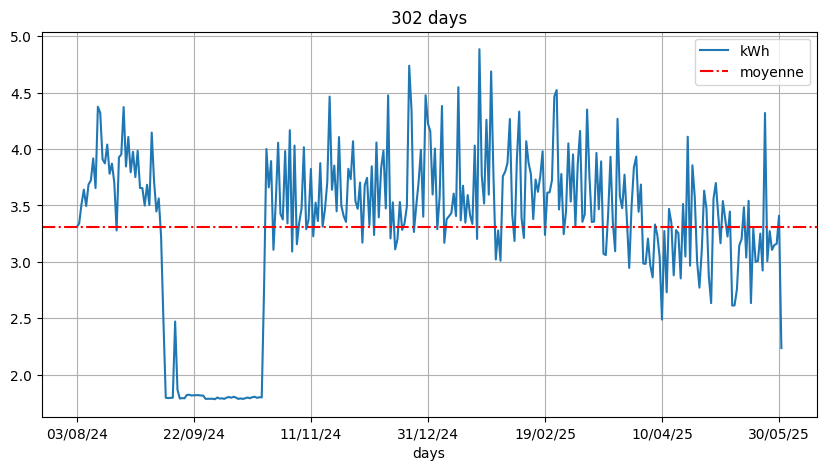

In [105]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

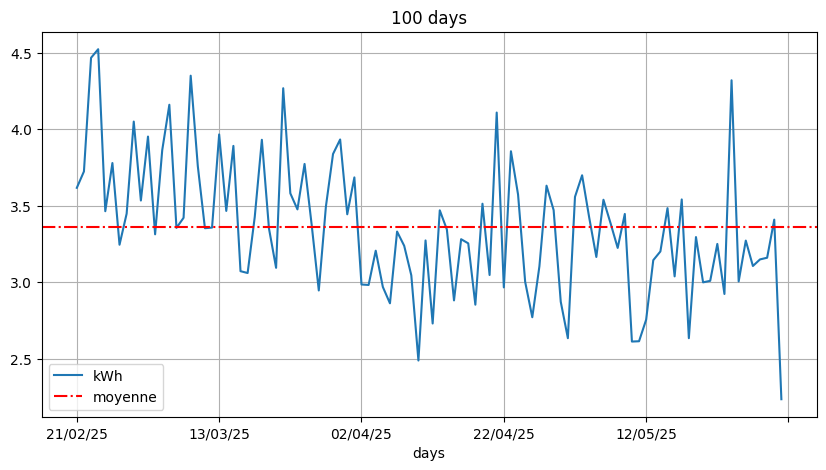

In [106]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [107]:
np.nanmean(df_grp.tail(span))

np.float64(3.36139)

In [108]:
df_grp['kWh']

days
03/08/24    3.309
04/08/24    3.341
05/08/24    3.511
06/08/24    3.640
07/08/24    3.495
            ...  
27/05/25    3.106
28/05/25    3.149
29/05/25    3.160
30/05/25    3.409
31/05/25    2.235
Name: kWh, Length: 302, dtype: float64

In [109]:
df_grp.describe()

,kWh
count,302.000000
mean,3.311258
std,0.728457
min,1.782000
25%,3.096500
50%,3.429000
75%,3.771250
max,4.885000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

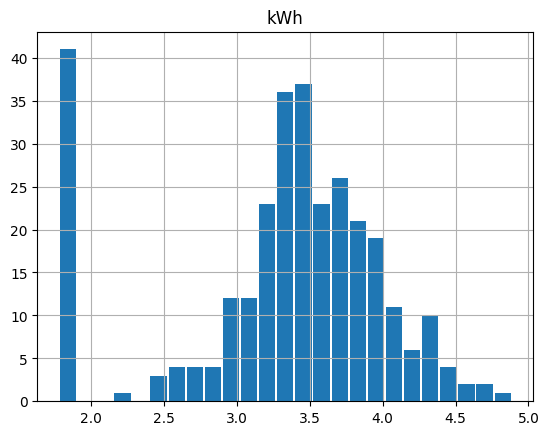

In [110]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [111]:
df_grp.tail(span)['kWh']

days
21/02/25    3.617
22/02/25    3.724
23/02/25    4.467
24/02/25    4.523
25/02/25    3.464
            ...  
27/05/25    3.106
28/05/25    3.149
29/05/25    3.160
30/05/25    3.409
31/05/25    2.235
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [112]:
day

'31/05/25'

In [113]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,122,122,NaN
01,103,225,-19.0
02,101,326,-2.0
03,100,426,-1.0
04,99,525,-1.0
05,99,624,0.0
06,105,729,6.0
07,101,830,-4.0
08,98,928,-3.0


In [114]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


21

In [115]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 22)

In [116]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [117]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

In [118]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
Name: days, dtype: float64

In [119]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [120]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 00 to 20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     21 non-null     int64  
 1   cumsum  21 non-null     int64  
 2   diff    20 non-null     float64
 3   days    21 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 840.0+ bytes


In [121]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
Name: days, dtype: float64

In [122]:
day

'31/05/25'

In [123]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,122,122,NaN,1.0
01,103,225,-19.0,2.0
02,101,326,-2.0,3.0
03,100,426,-1.0,4.0
04,99,525,-1.0,5.0
05,99,624,0.0,6.0
06,105,729,6.0,7.0
07,101,830,-4.0,8.0
08,98,928,-3.0,9.0


In [124]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_2748\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(2.2350000000000003)

In [125]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
03/08/24 00     102     102   NaN   NaN
         01     127     229  25.0   NaN
         02     191     420  64.0   NaN
         03     154     574 -37.0   NaN
         04     125     699 -29.0   NaN
...             ...     ...   ...   ...
31/05/25 16      99    1828   2.0  17.0
         17     102    1930   3.0  18.0
         18      98    2028  -4.0  19.0
         19      96    2124  -2.0  20.0
         20     111    2235  15.0  21.0

[7245 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '31/05/25: kWh    2.235\ndtype: float64')

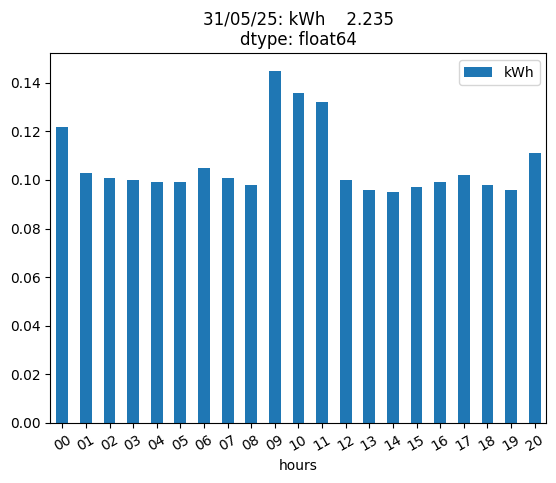

In [126]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [127]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='hours')

# Conso du jour


In [128]:
grp_by_dayhours.count()

kWh       7245
cumsum    7245
diff      6943
days        21
dtype: int64

'22/01/25'

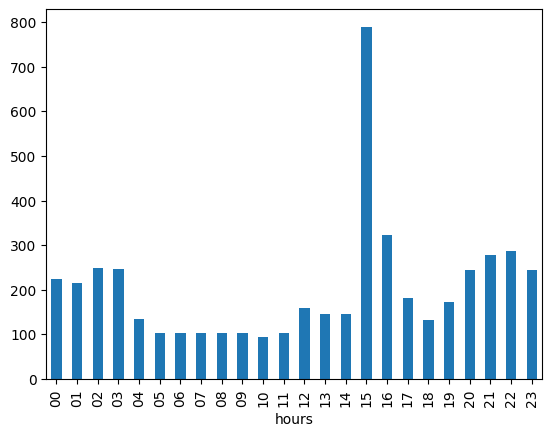

In [129]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [130]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 336.139 , Moyenne= 3.36139


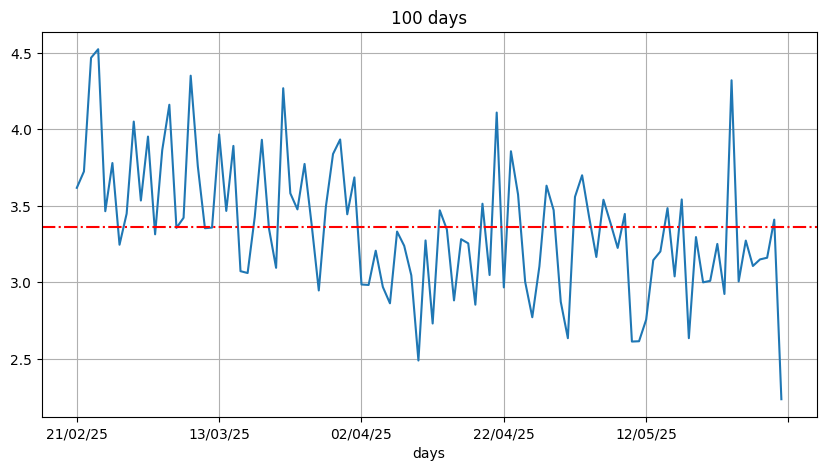

In [131]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [132]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 20:43:54, Minutes in day: 1243


In [133]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [134]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:17.06


In [135]:
end - start

77.05854344367981

In [136]:
#df = conso_day
show_tranches()

3
2025-05-31 00:00:13.244679	2025-05-31 09:45:54.216679	9h 45m 40s 	1000
2025-05-31 09:45:54.216679	2025-05-31 18:47:22.552679	9h 1m 28s 	2000
2025-05-31 18:47:22.552679	2025-05-31 20:42:38.558679	1h 55m 16s 	235


In [137]:
df_grp.tail(7)['kWh']

days
25/05/25    3.005
26/05/25    3.272
27/05/25    3.106
28/05/25    3.149
29/05/25    3.160
30/05/25    3.409
31/05/25    2.235
Name: kWh, dtype: float64

<Axes: xlabel='days'>

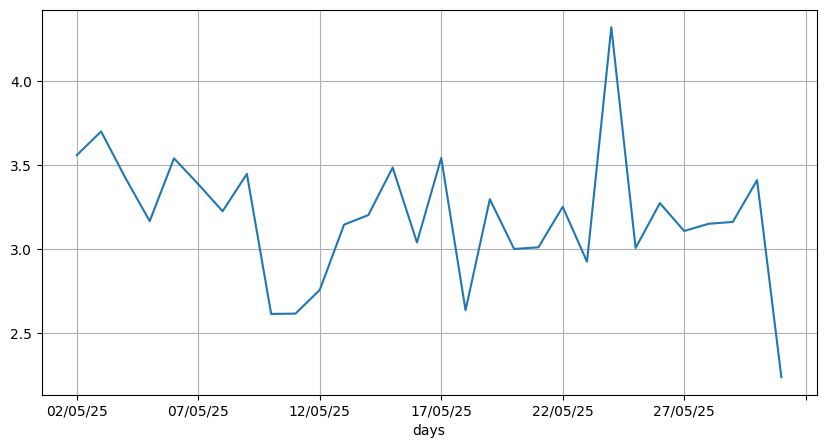

In [138]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)

# Today

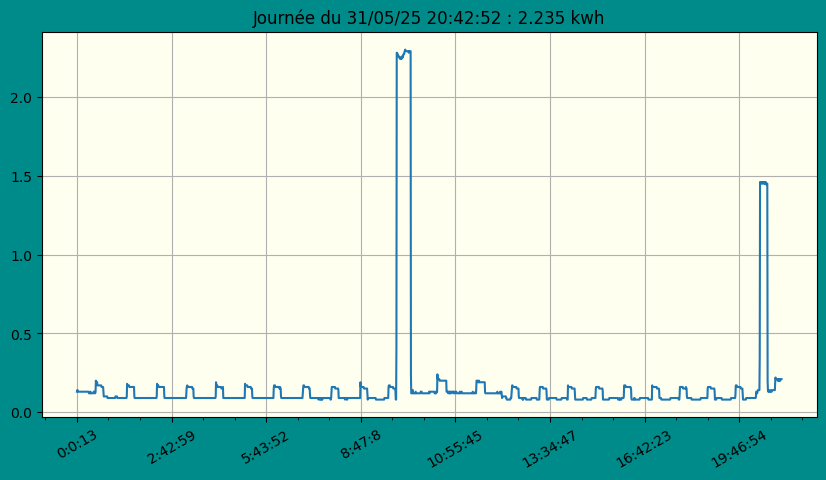

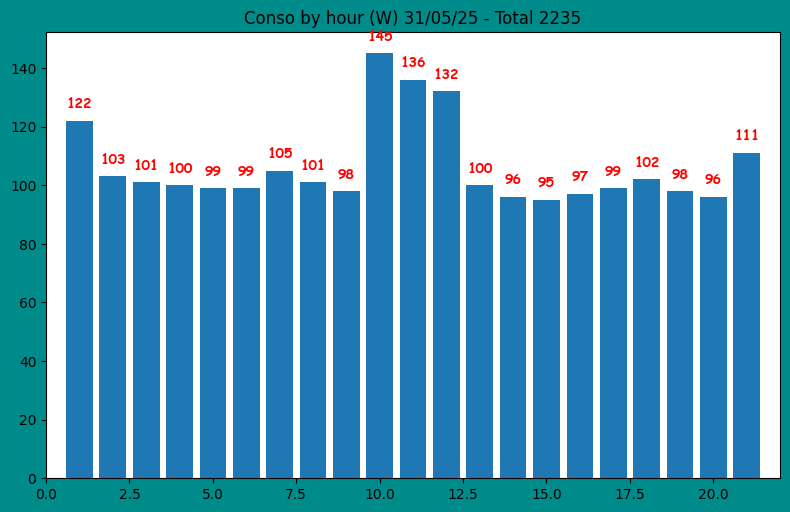

In [139]:
show(today,bgcolor='ivory')
conso_by_hour(today)

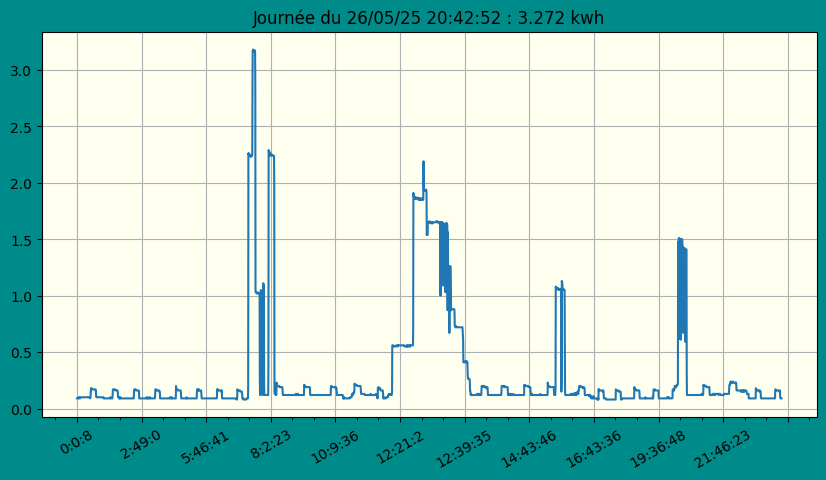

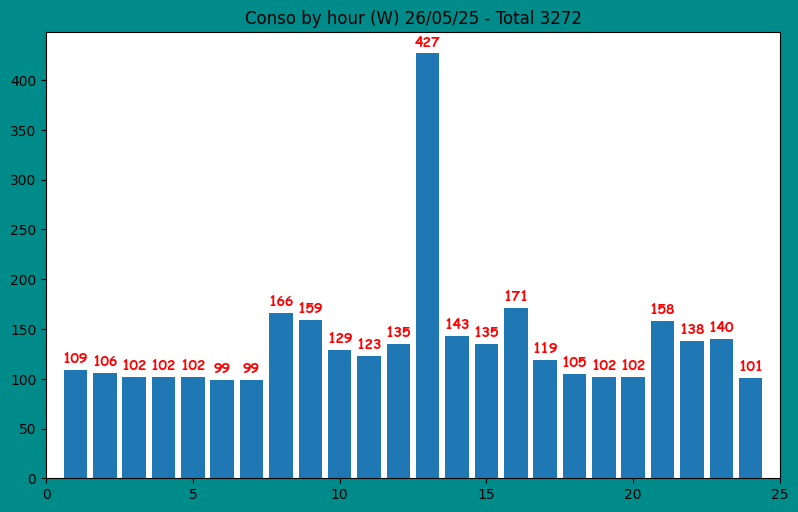

In [140]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4885)

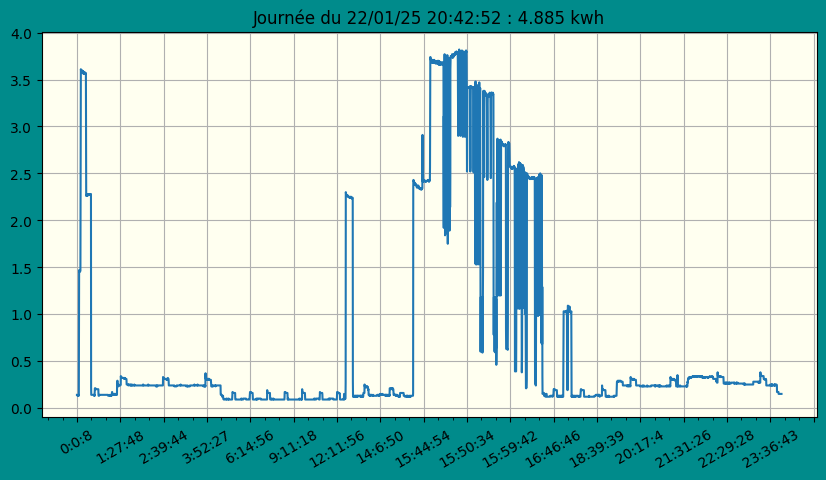

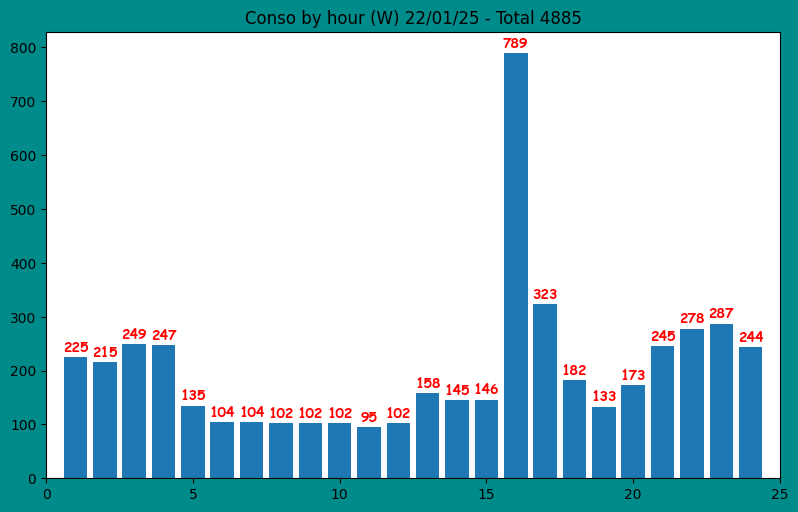

In [141]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

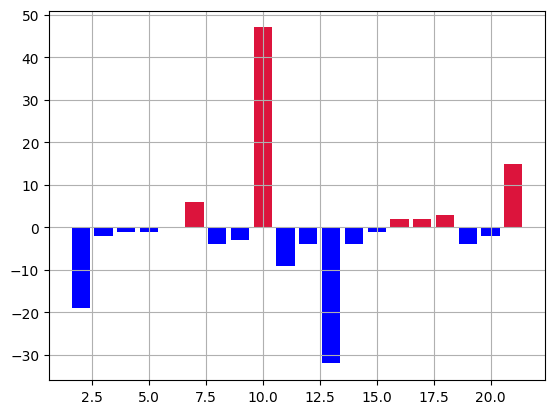

In [142]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

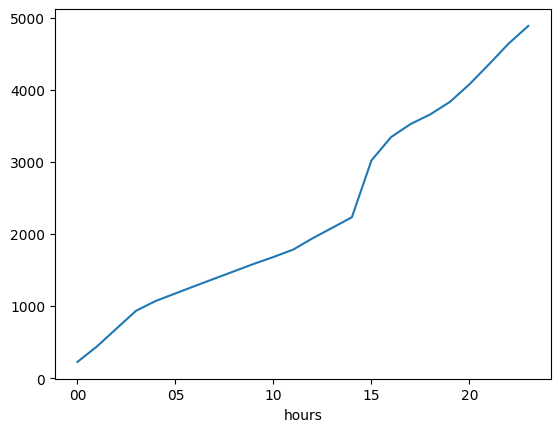

In [143]:
data.cumsum().plot()


<Axes: xlabel='hours'>

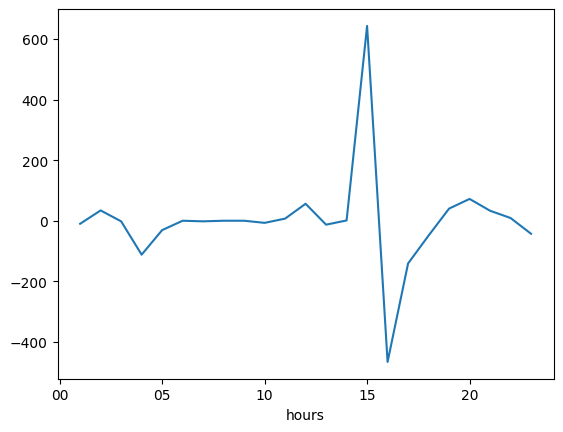

In [144]:
# evolution par heure
data.diff().plot()

In [145]:
data.diff().describe()

count     23.000000
mean       0.826087
std      175.919313
min     -466.000000
25%      -22.000000
50%        0.000000
75%       21.000000
max      643.000000
Name: kWh, dtype: float64

<Axes: >

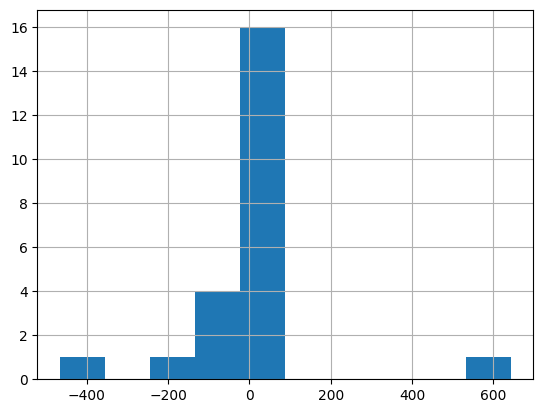

In [146]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [147]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo

# list store files csv


In [148]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

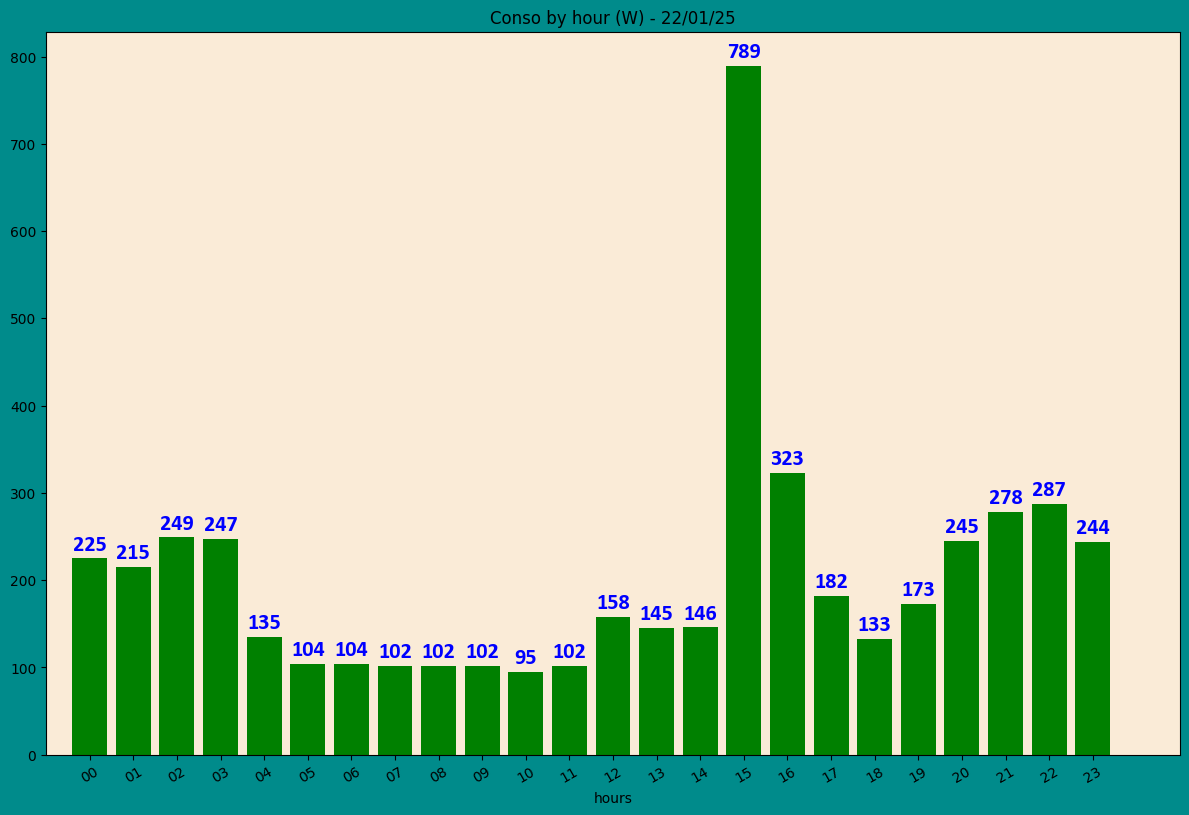

In [149]:
day,conso_byhour(day)

In [150]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


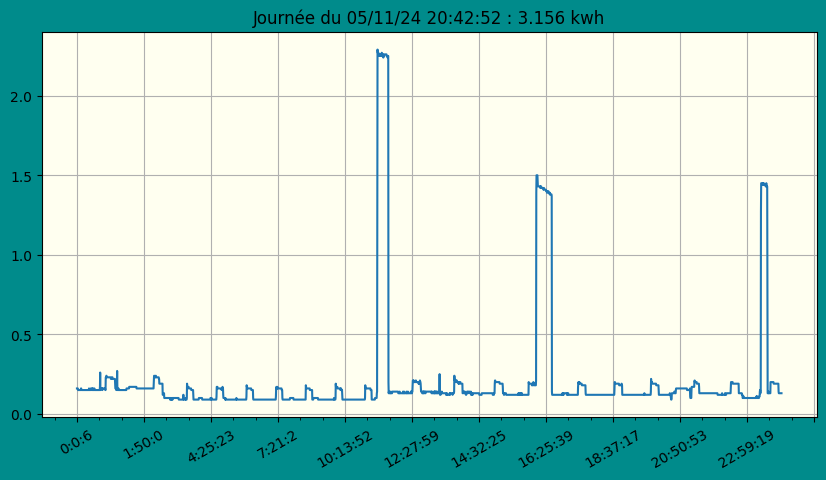

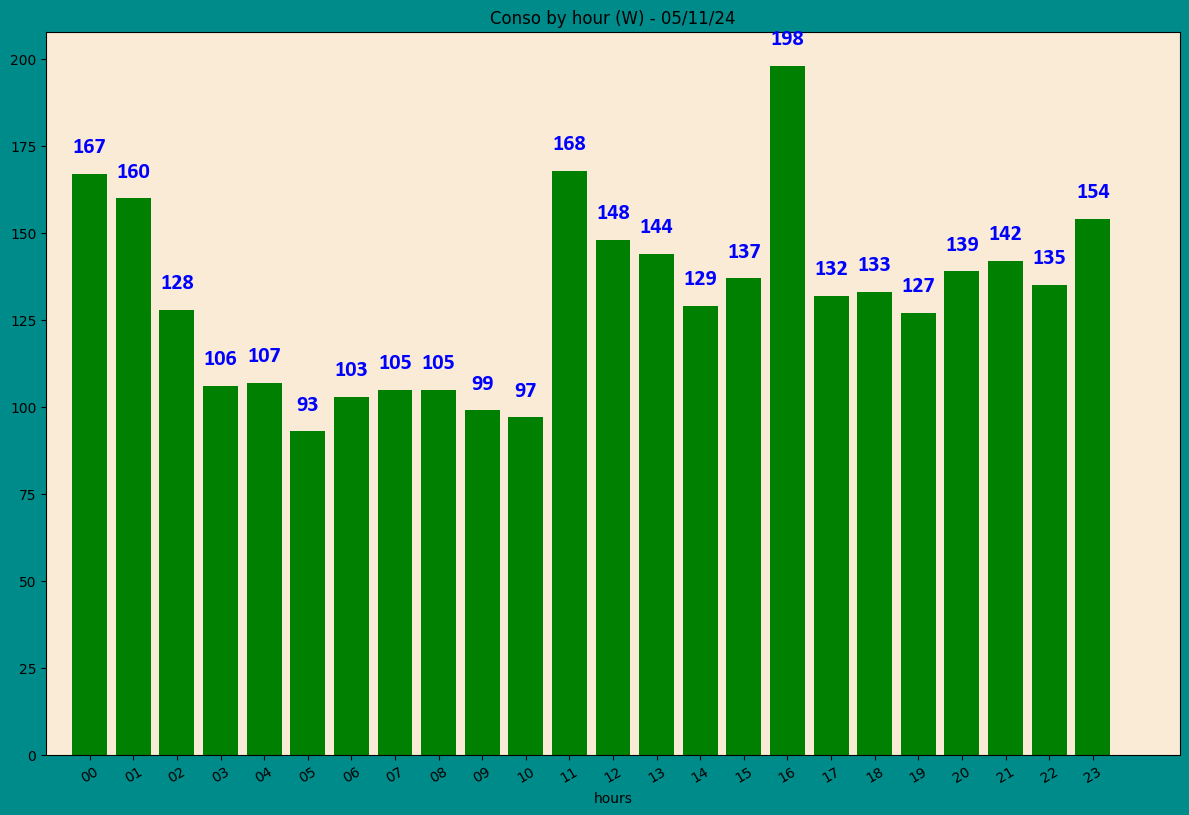

In [151]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [152]:
month

,day,hours,months,kWh
805981,01,00,2025-04,0.21
805982,01,00,2025-04,0.21
805983,01,00,2025-04,0.21
805984,01,00,2025-04,0.20
805985,01,00,2025-04,0.20
...,...,...,...,...
901768,30,23,2025-04,0.09
901769,30,23,2025-04,0.09
901770,30,23,2025-04,0.09
901771,30,23,2025-04,0.09


In [153]:
month.describe()


,kWh
count,95792.000000
mean,0.310159
std,0.548010
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

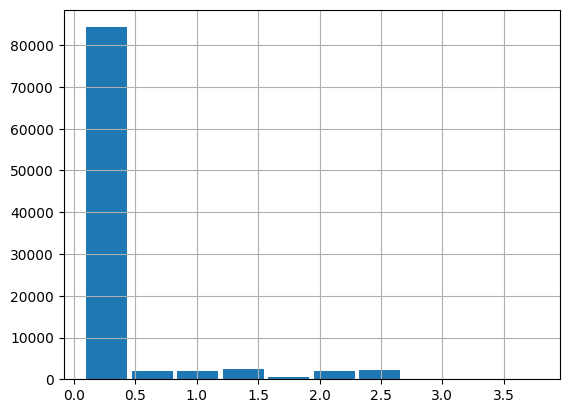

In [154]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

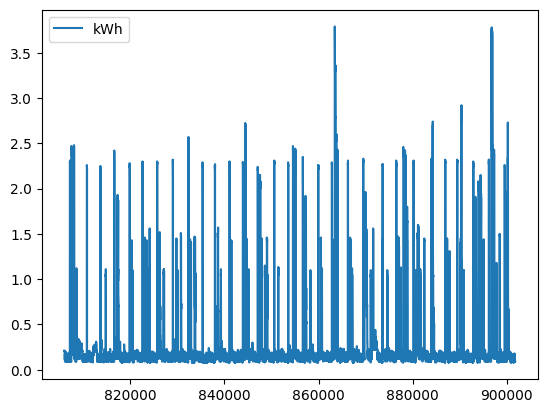

In [155]:
month.plot()

In [156]:
# index with max conso in this month
month.idxmax().kWh

np.int64(863444)

In [157]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       898901
hours     809456
months    805981
kWh       863444
dtype: int64

In [158]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [159]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
03/08/24 00     102     102   NaN   NaN
         01     127     229  25.0   NaN
         02     191     420  64.0   NaN
         03     154     574 -37.0   NaN
         04     125     699 -29.0   NaN
...             ...     ...   ...   ...
31/05/25 16      99    1828   2.0  17.0
         17     102    1930   3.0  18.0
         18      98    2028  -4.0  19.0
         19      96    2124  -2.0  20.0
         20     111    2235  15.0  21.0

[7245 rows x 4 columns]

In [160]:
month

,day,hours,months,kWh
805981,01,00,2025-04,0.21
805982,01,00,2025-04,0.21
805983,01,00,2025-04,0.21
805984,01,00,2025-04,0.20
805985,01,00,2025-04,0.20
...,...,...,...,...
901768,30,23,2025-04,0.09
901769,30,23,2025-04,0.09
901770,30,23,2025-04,0.09
901771,30,23,2025-04,0.09


In [161]:
month.idxmax()


day       898901
hours     809456
months    805981
kWh       863444
dtype: int64

In [162]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 863444, dtype: object

In [163]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       167
          01       136
          02       114
          03       111
          04       100
          05       109
          06       111
          07       110
          08        98
          09       109
          10       164
          11       143
          12       136
          13       145
          14       144
          15       200
          16       151
          17       182
          18       160
          19       147
          20       142
          21       170
          22       226
          23       173
Name: kWh, dtype: int64

In [164]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

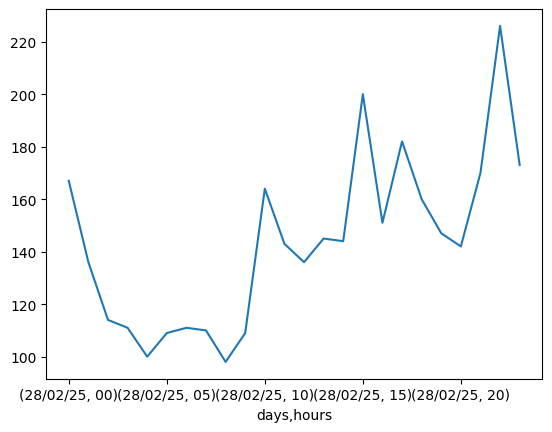

In [165]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [166]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [167]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [168]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [169]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB